# Mapping Mangrove Change in Mozambique

This notebook originates from research conducted in the field of GIS Modeling at Universidade Nova de Lisboa - IMS. <br>
The code presented here corresponds to the implementation discussed in the article titled 'XXX.' <br>
We kindly request that you acknowledge our work by citing the article and referencing this code in your own research. Thank you for your consideration.


# Mangroves
Mangroves are vital coastal ecosystems found in tropical and subtropical regions. These complex habitats consist of trees and shrubs that flourish in brackish water and provide a plethora of benefits to both wildlife and humans. They are exceptional carbon sequesters and serve as nurseries for marine species, while also protecting shorelines from erosion. However, mangroves are under threat from human activities such as deforestation, urbanization, and aquaculture, as well as the impacts of climate change, including sea level rise and intensified storms. This study focuses on analyzing the evolution of the mangrove ecosystem over time, using the Random Forest (RF) and the Support Vector Machine (SVM) method. The model considers distance to rivers and roads as significant drivers and yields an impressive accuracy of 99%. The analysis is conducted as part of the MozambES project, which aims to promote sustainable management of mangrove ecosystems in Sofala Province and enhance the livelihoods of rural communities. By providing insight into the changes in mangrove ecosystems, this study will contribute to the project's goal of improving the management and conservation of these vital coastal habitats. 

# Pre Processing
While it would be feasible to execute the entire code using commercial software such as ArcGIS Pro, our choice has been to undertake the majority of this project in an open-source approach. <br>

The initial stage involves acquiring the necessary data. For this project, we obtained a significant portion of the data, including shapefiles for rivers, roads, and buildings, from OpenStreetMap. All acquired data were georeferenced to WGS 1984 UTM Zone 37S. <br>

Subsequently, in QGIS, we calculated the distances to roads, rivers, coastlines, and buildings using the Euclidean distance method. While this distance calculation could have been performed here using gdal.ComputeProximity, it was opted to conduct this step in QGIS.<br>

The Mangrove Classification was manualy performed using Google Earth Engine.

# Importing Libraries

If you don't have already an python environment for Geospatial analysis, please follow the steps: <br>
* Install Anaconda.
* Open conda prompt.
* Create a new environment: conda create --name your_env_name
* Activate the environment: conda activate your_env_name
* Install some packages: conda install -c conda-forge geopandas cartopy pyproj rasterio plotly joblib seaborn geodatasets



In [2]:
# Standard Libraries
import os
import shutil
import glob

# Numerical and Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, cohen_kappa_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import cartopy.crs as ccrs
import contextily as cx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar
import cartopy.feature as cfeat
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.colors import ListedColormap

# Geospatial Libraries
import geopandas as gpd
import geodatasets
import pyproj
import rasterio 
from rasterio import plot as rasterplot
from rasterio.plot import show

# GIS Specific Libraries
from osgeo import gdal

# Other Libraries
import joblib

# Additional imports
from sklearn.metrics import confusion_matrix, roc_curve, auc
from itertools import cycle
from sklearn.utils.multiclass import type_of_target

# Inline Plotting
%matplotlib inline
%config InlineBackend.figure_format='retina'

C:\Users\User\AppData\Local\Temp\ipykernel_14040\593919422.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Set paths and create an output folder

In [47]:
# Set the input and output folder paths

# input_folder = 'D:/OneDrive - TPF/Documentos/Pos_graduaçao/ModSIG/Artigo/Dados_30_10'
input_folder = "Path_in"
# output_folder = 'D:/OneDrive - TPF/Documentos/Pos_graduaçao/ModSIG/Artigo/Dados_30_10/output_folder'
output_folder ="Path_out"

# # Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
     os.makedirs(output_folder)

# Set current folder

In [ ]:
current_directory = os.getcwd()
print(current_directory)
os.chdir(output_folder)

# Read Features
Import the distance rasters used as drivers, as well as the classified Mangrove images for the year of 2011, 2016 and 2021. <br>
Make sure all images are with the same size (rows,cols), if not you will have problem when training models

In [7]:
%%time

images = {}

for index, input_file in enumerate(glob.glob(os.path.join(input_folder, '*.tif'))):
# Open the raster image file in read mode
    with rasterio.open(input_file,'r') as src:
        root, ext = os.path.splitext(input_file)
        name = str(input_file.split('_')[-1].split('.')[0])
        #name = root[-4:]
        print(name)
        # Read the input raster data as a numpy array
        data = src.read(1)
        images[name] = data

    # Print the shape of the numpy array
    print('Shape of the numpy array:', data.shape)


building
Shape of the numpy array: (8418, 4228)
coast2
Shape of the numpy array: (8418, 4228)
rivers4
Shape of the numpy array: (8418, 4228)
road
Shape of the numpy array: (8418, 4228)
2011
Shape of the numpy array: (8418, 4228)
2016
Shape of the numpy array: (8418, 4228)
2021
Shape of the numpy array: (8418, 4228)
CPU times: total: 516 ms
Wall time: 503 ms


# Visualize the data

I have two types of data: the distances which I plot with the viridis colormap, and the Mangrove classification, which I plot with a binary colormap

building


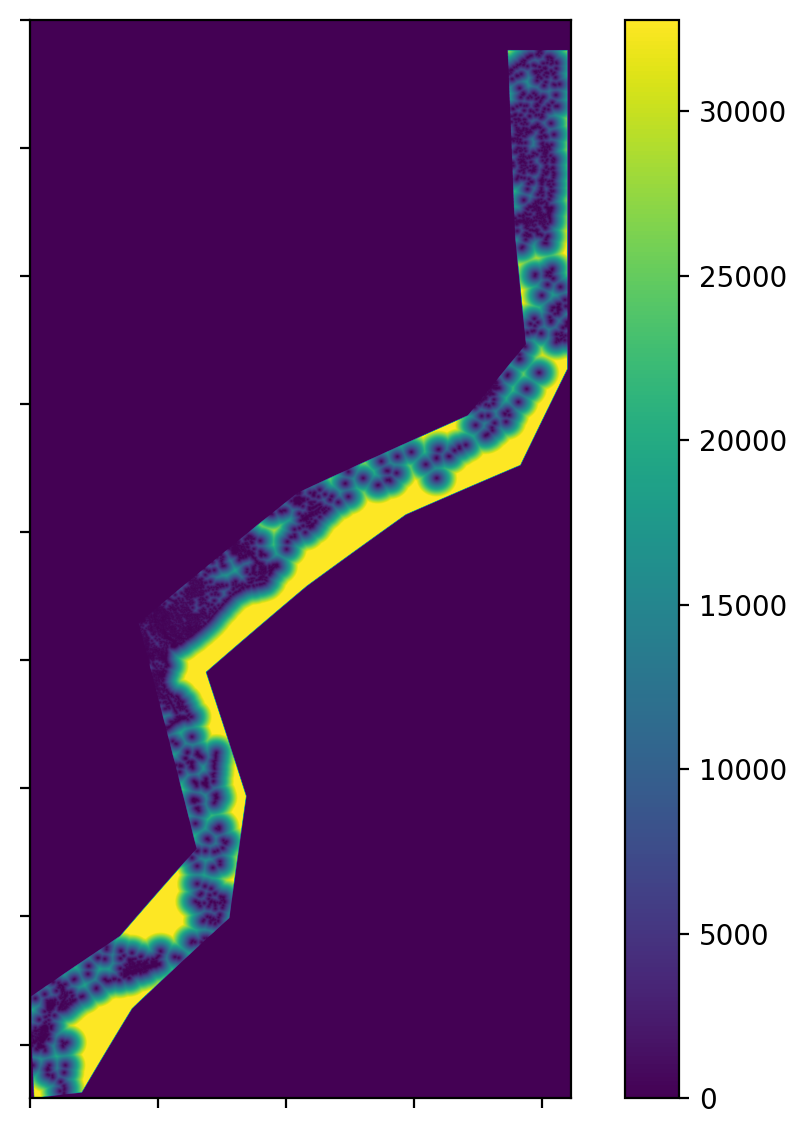

coast2


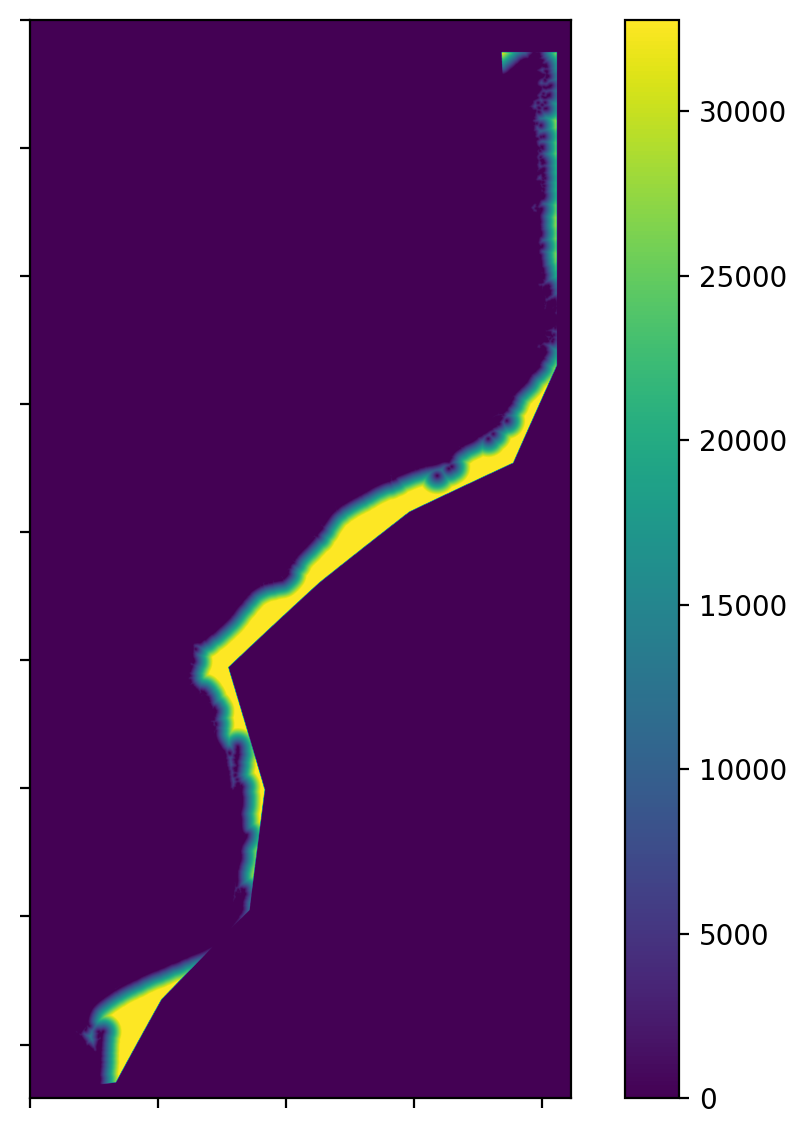

rivers4


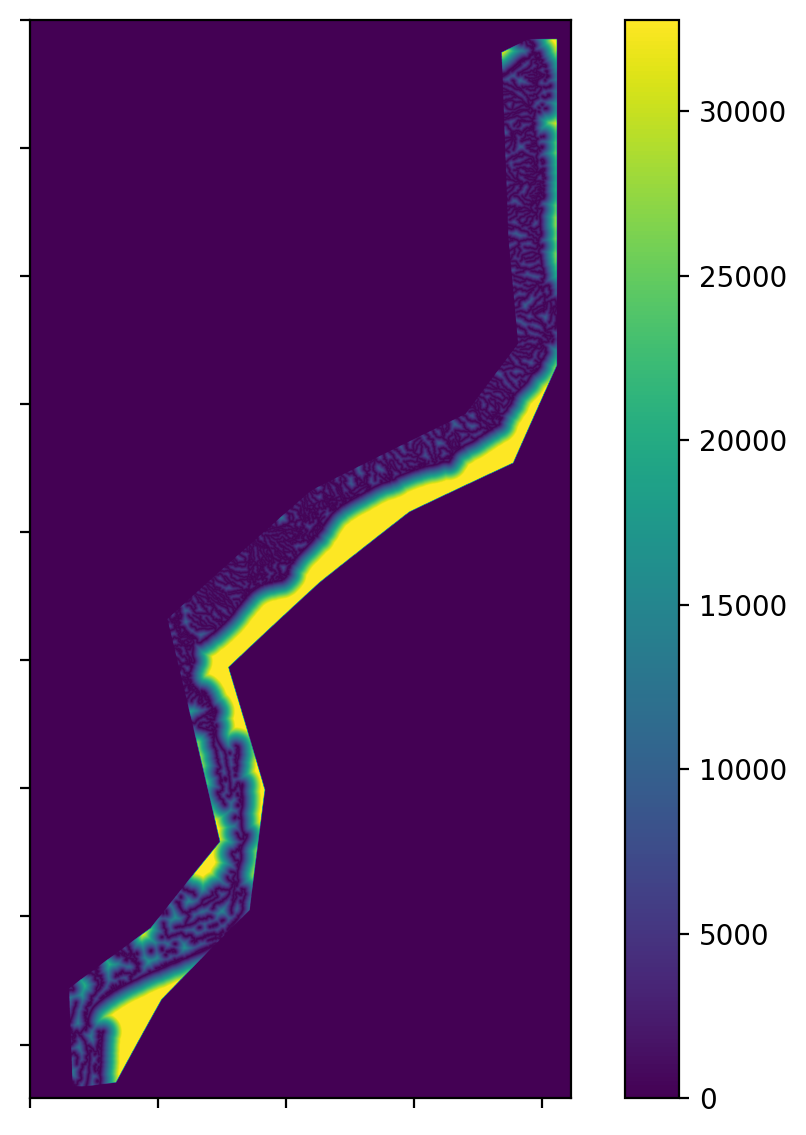

road


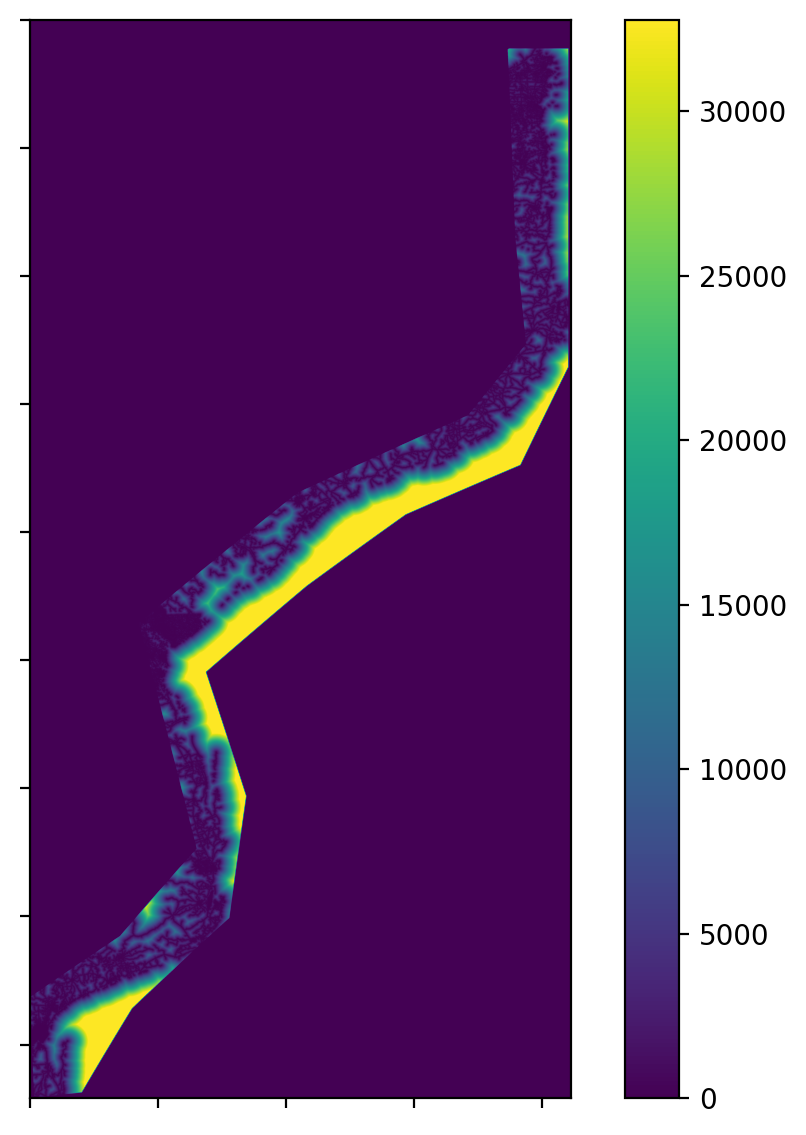

2011


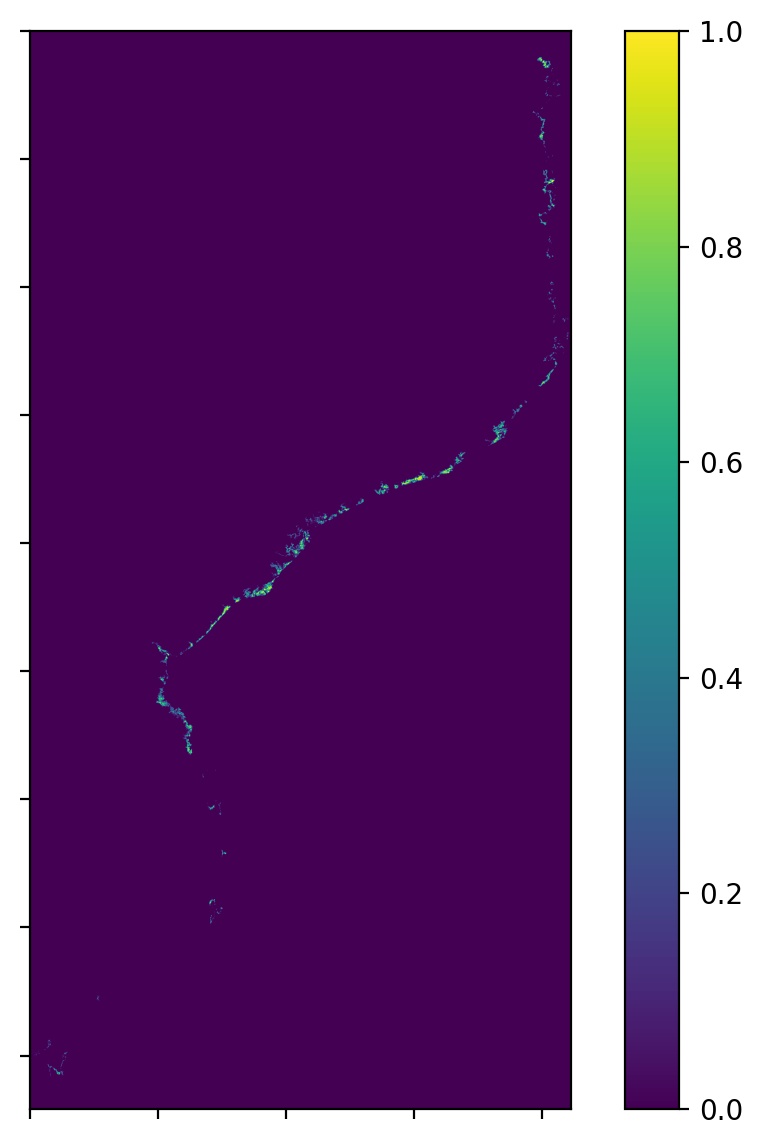

2016


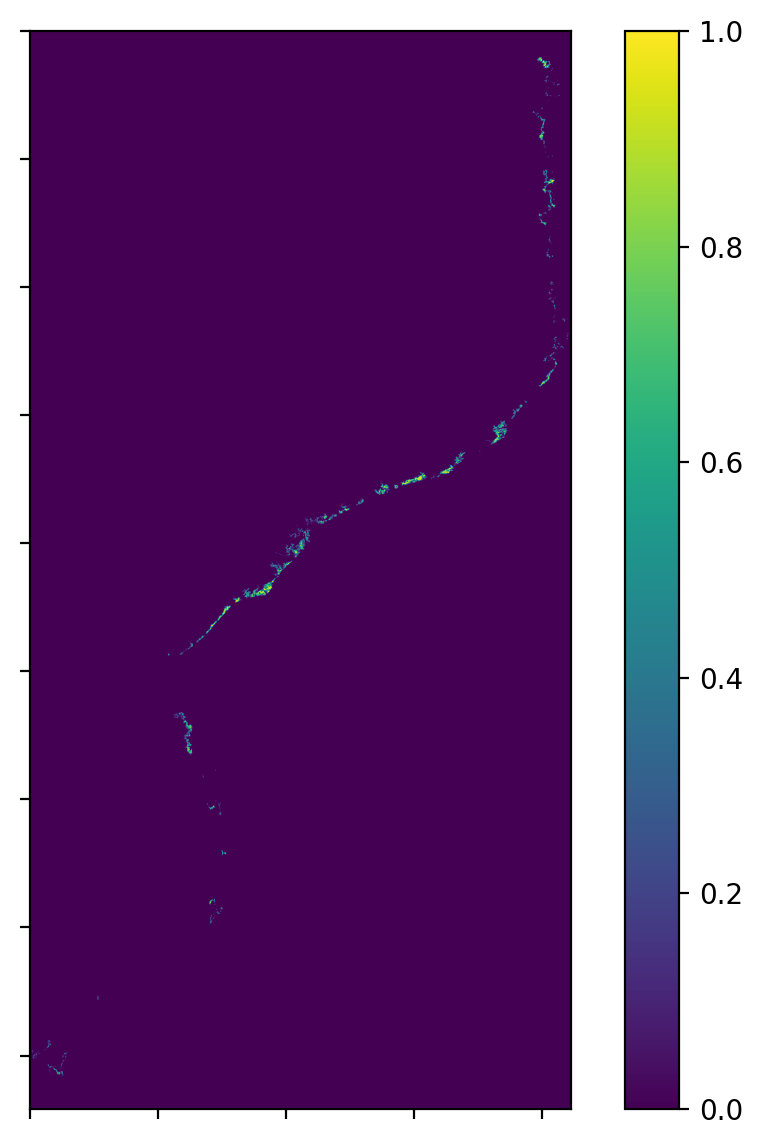

2021


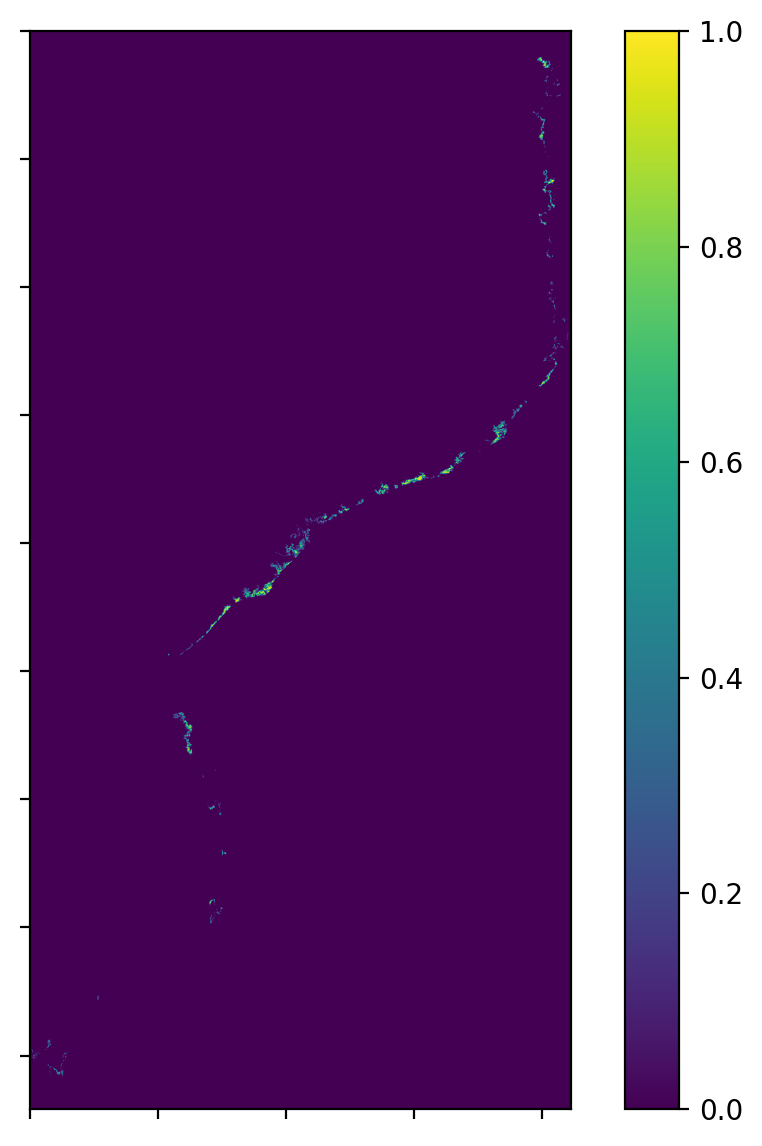

CPU times: total: 9.34 s
Wall time: 9.35 s


In [8]:
%%time



# Loop through all images


for name, data in images.items():
    print(name)
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))

    im = ax.imshow(data)
    cbar = fig.colorbar(im, orientation='vertical', pad=0.05)
    #plt.savefig(str(name)+'IG.png',format='png',transparent=True)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.show()


# Let's get the projection of the rasters so later when we need to export we know how to export

In [9]:
bands_data = []
for index, input_file in enumerate(glob.glob(os.path.join(input_folder, '*.tif'))):
    ras = gdal.Open(input_file,gdal.GA_ReadOnly)
    #geotransformation
    gt = ras.GetGeoTransform()
    proj = ras.GetProjectionRef()
    #Importing bands as a set of arrays
    n_bads = ras.RasterCount
    band =  ras.GetRasterBand(1)
    band= band.ReadAsArray()
    band_vector=band.reshape(1, band.shape[0]*band.shape[1])
    band_vector=np.transpose(band_vector)
    bands_data.append(band_vector)
#     print('gt: ',gt)
#     print('proj: ',proj)
#     print('Band: ', index, ' is imported')

C:\Users\User\anaconda3\envs\geospatial\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


# I'm used to work with pandas dataframe, so intermediate step, maybe not necessary

In [10]:
reshaped_images = {key: value.flatten() for key, value in images.items()}
images_df = pd.DataFrame(reshaped_images)

In [11]:
images_df.head()

building  coast2  rivers4  road  2011  2016  2021
0         0       0        0     0     0     0     0
1         0       0        0     0     0     0     0
2         0       0        0     0     0     0     0
3         0       0        0     0     0     0     0
4         0       0        0     0     0     0     0

In [12]:
images_df['2016'].unique()

array([0, 1], dtype=int16)

Thats good, we have only the class 0 and 1, as expected

## Problem:
### Get the label (Y), with a machine learning method
### For the training data:
* Drivers:Distance to rivers, coast, building, roads etc.
* Mangrove vegetation at 2011

In [13]:
X = images_df.drop(['2016','2021'], axis = 1) # Features

## Training to 2021

In [14]:
Y_2021 = images_df['2021'].values

###  Let's check our labels

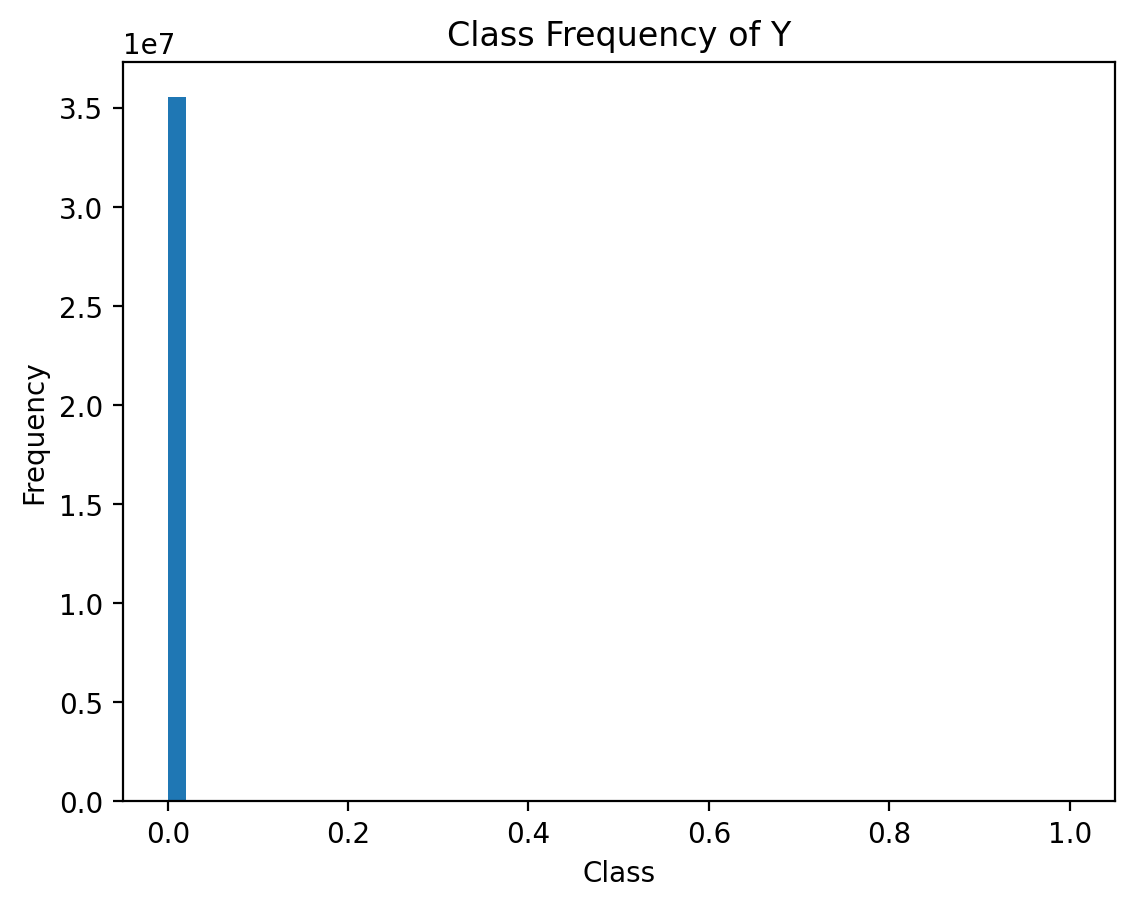

In [15]:
plt.hist(Y_2021, bins=50)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Frequency of Y')
plt.show()

As you can see we have a problem of imbalaced data, since most of our data is "non mangrove", so let's apply some techniques to improve that

## OverSampling
(or Undersampling)

In [16]:
%%time
sampler = RandomOverSampler(random_state=0)
# sampler = RandomUnderSampler(random_state=0)
X_res, Y_res = sampler.fit_resample(X, Y_2021)

CPU times: total: 4.44 s
Wall time: 4.43 s


### Checking again our data...

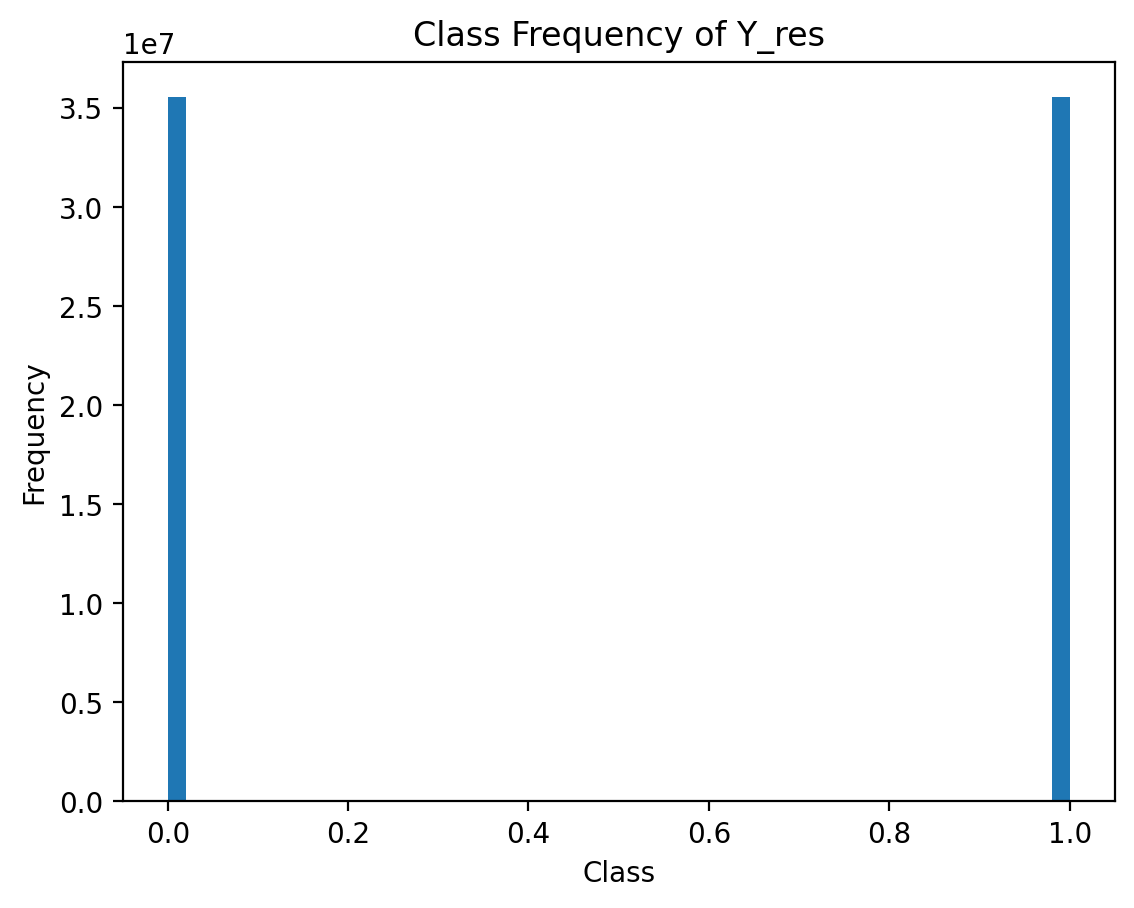

In [17]:
plt.hist(Y_res, bins=50)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Frequency of Y_res')
plt.show()

Now our data are balanced, let's train our model

# Creating a Model

## * Randon Forest

In [18]:
%%time
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, Y_res, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier with desired hyperparameters and binary=True
rf_classifier = RandomForestClassifier(n_estimators=200, criterion='gini',random_state = 42)

CPU times: total: 7.47 s
Wall time: 7.47 s


The next step can take a while and if you raster is too large maybe will not finished, try modifying the spatial resolution

In [19]:
%%time
rf_classifier.fit(X_train,y_train)

CPU times: total: 3h 41min 56s
Wall time: 22h 18min 52s


RandomForestClassifier(n_estimators=200, random_state=42)

### Evaluate the model

In [20]:
%%time

print("accuracy on training set: %f" % rf_classifier.score(X_train, y_train))
print("accuracy on test set: %f" % rf_classifier.score(X_test, y_test))

accuracy on training set: 0.999952
accuracy on test set: 0.999844
CPU times: total: 24min 38s
Wall time: 24min 38s


### Check Feature importances

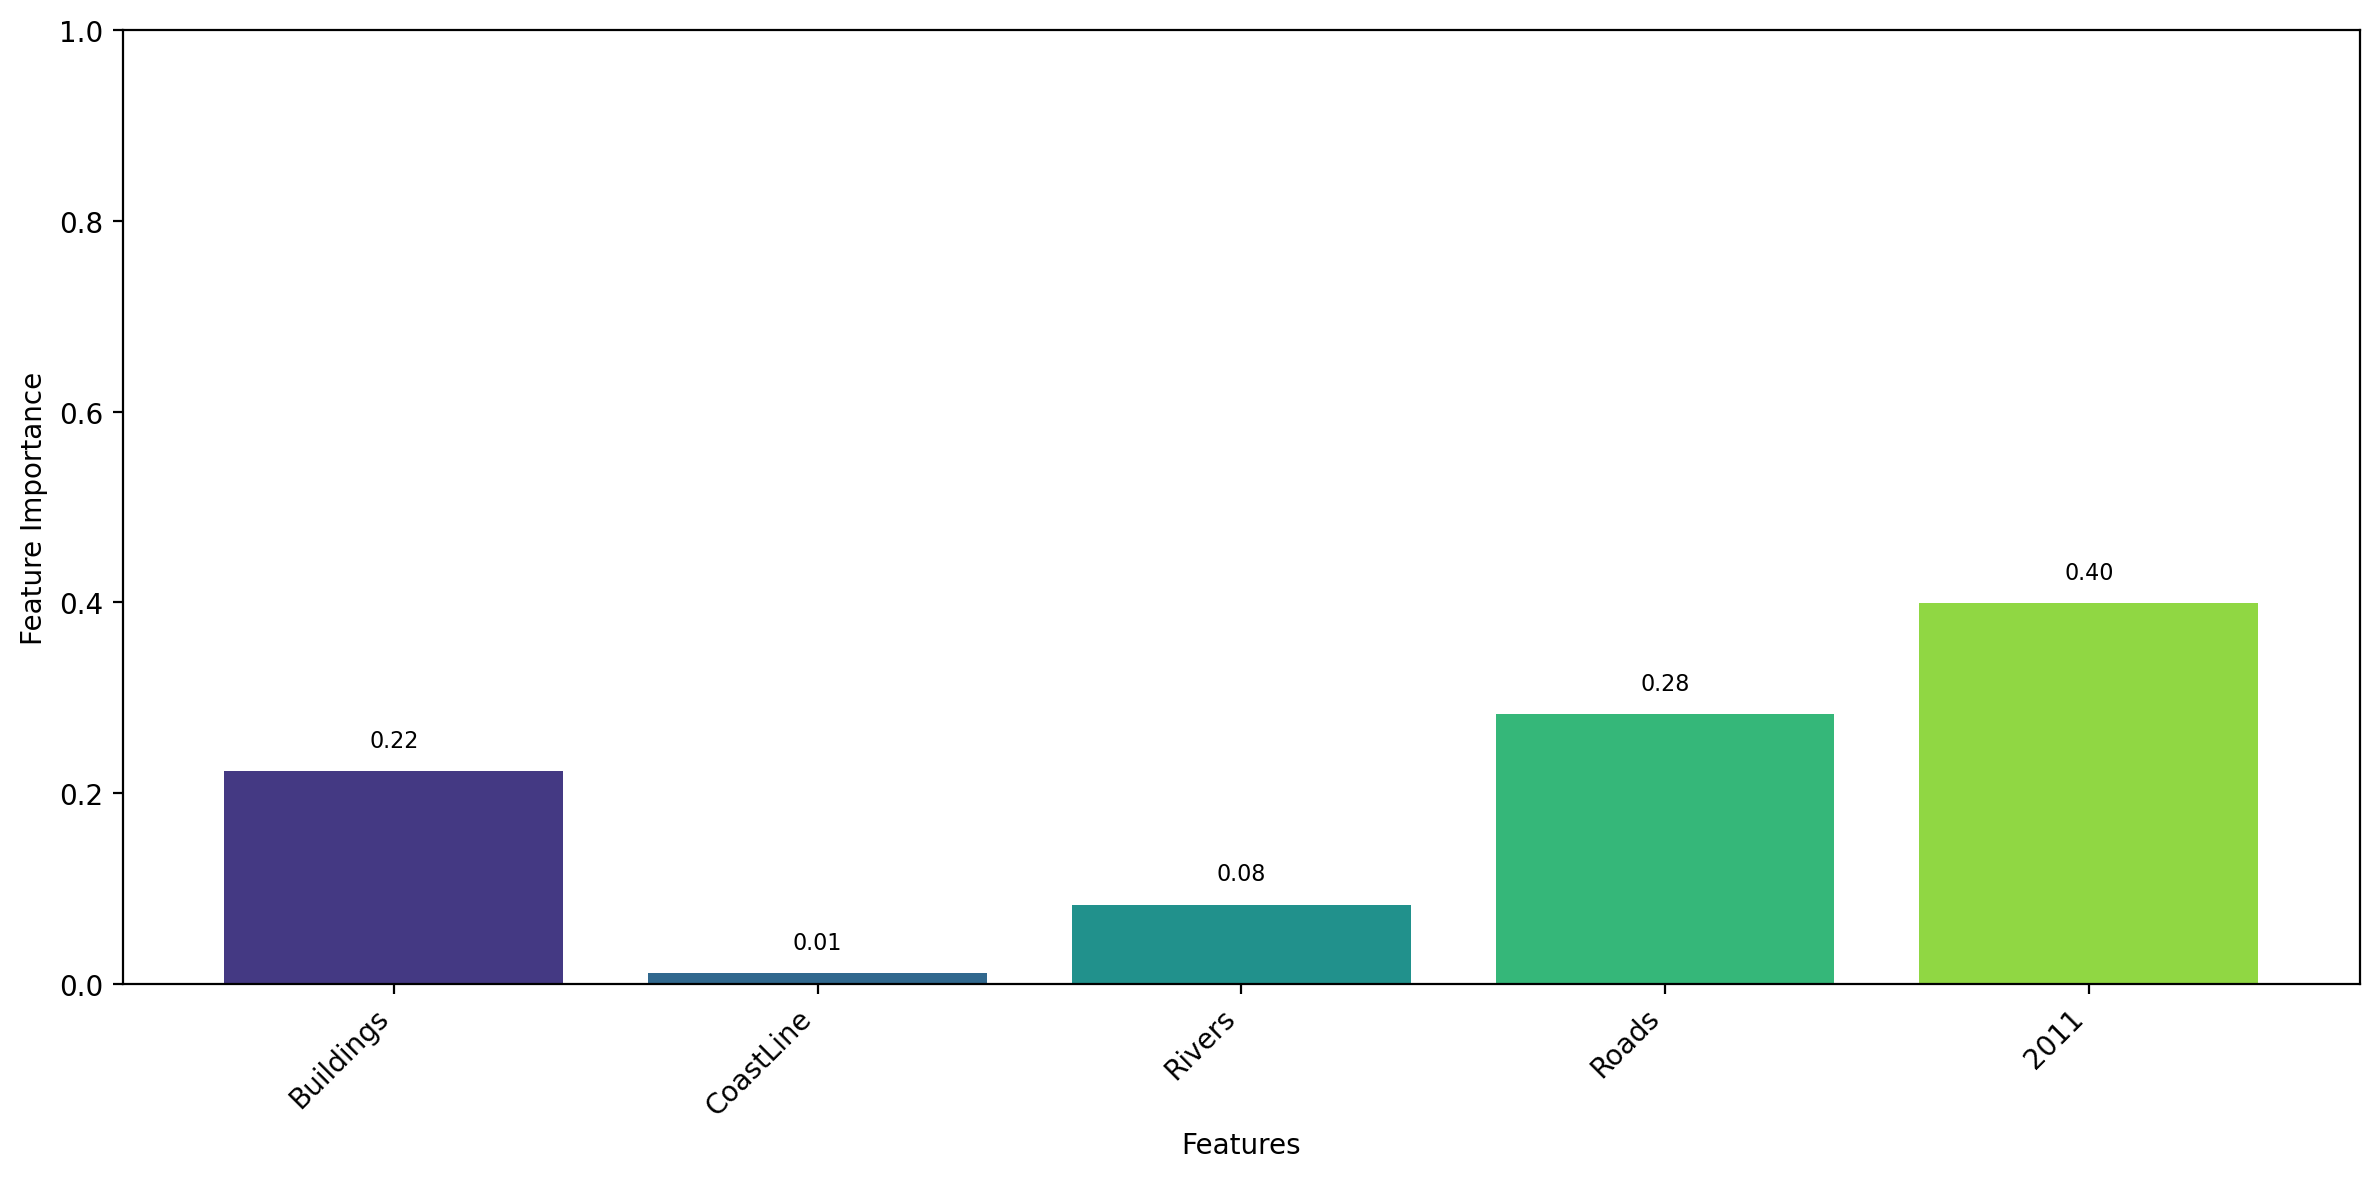

In [21]:
custom_labels = ['Buildings', 'CoastLine', 'Rivers', 'Roads', '2011']

# Plotting the feature importances
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(X.shape[1]), rf_classifier.feature_importances_, color=sns.color_palette("viridis", len(X.columns)))
ax.set_xticks(range(X.shape[1]))
ax.set_xticklabels(custom_labels, rotation=45, ha="right")  # Use custom_labels instead of X.columns
ax.set_ylim(0, 1)
ax.set_ylabel('Feature Importance')
ax.set_xlabel('Features')
ax.grid(False)


# Customize axis lines and ticks
ax.tick_params(color='black', labelcolor='black')
for spine in ax.spines.values():
    spine.set_edgecolor('black')

# Adding data labels on top of the bars
for i, v in enumerate(rf_classifier.feature_importances_):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

# Save the plot
plt.tight_layout()
plt.savefig('feature_importance_plot.png')

# Show the plot
plt.show()


### Save the model
It is always considered good practice to save your model. This ensures that you can return later to create plots or perform other tasks without the need to rerun the entire process.

In [22]:
filename = 'Forest_1.sav'
joblib.dump(rf_classifier, filename)

['Forest_casa.sav']

### Make some predictions

In [23]:
%%time
y_2021_pred = rf_classifier.predict(X_test)

CPU times: total: 4min 57s
Wall time: 4min 57s


### Display the Confusion Matrix

In [24]:
cm = confusion_matrix(y_test, y_2021_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[7105286    1851]
 [    364 7106979]]


In [25]:

print(classification_report(y_test, y_2021_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7107137
           1       1.00      1.00      1.00   7107343

    accuracy                           1.00  14214480
   macro avg       1.00      1.00      1.00  14214480
weighted avg       1.00      1.00      1.00  14214480



### Plot a ROC curve

In [26]:
y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

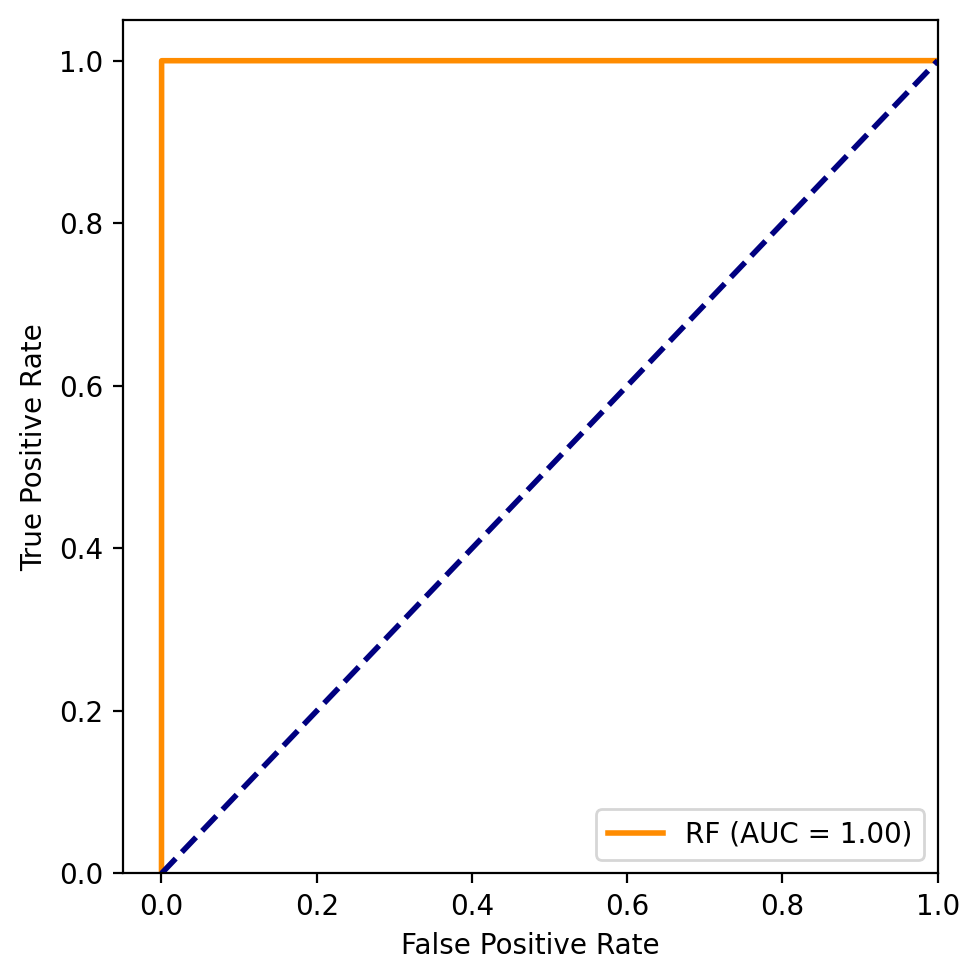

In [27]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the ROC curve
roc_label = 'RF (AUC = %0.2f)' % roc_auc
ax.plot(fpr, tpr, ls='-', color='darkorange', lw=2, label=roc_label)

# Plot the diagonal line
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Set x and y axis limits
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])

# Set x and y axis labels
ax.set_xlabel('False Positive Rate', color='black')
ax.set_ylabel('True Positive Rate', color='black')

# Set tick colors
ax.tick_params(axis='both', colors='black')

# Customize spines (axes lines and borders)
for spine in ax.spines.values():
    spine.set_edgecolor('black')

# Add legend
ax.legend(loc="lower right")
plt.tight_layout()
# Save the plot
plt.savefig('rocx1.png', bbox_inches='tight')

# Show the plot
plt.show()

### Check the Kappa coef.

In [28]:
kappa_ = cohen_kappa_score(y_test, y_2021_pred)
kappa_

0.999688345967326

### Now, let's modify our Mangrove classification image to get the prediction for a certain period

In [29]:
X2016 = images_df.drop(['2021','2011'], axis = 1)
X2021 = images_df.drop(['2016','2011'], axis = 1)
X2011 = images_df.drop(['2016','2021'], axis = 1)
X2016.rename(columns={'2016':'2011'}, inplace=True)
X2021.rename(columns={'2021':'2011'}, inplace=True)

In [30]:
%%time
y_pred_2016 = rf_classifier.predict(X2016)
y_pred_2031 = rf_classifier.predict(X2021)
y_pred_2021 = rf_classifier.predict(X2011)

CPU times: total: 9min 3s
Wall time: 9min 3s


In [31]:
# Reshape to make sure we have all the same size

ras_2011 = images_df['2011'].values.reshape(8418, 4228)
ras_2021 = images_df['2021'].values.reshape(8418, 4228)
ras_2016 = images_df['2016'].values.reshape(8418, 4228)
ras_2016_pred = y_pred_2016.reshape(8418, 4228)
ras_2021_pred = y_pred_2021.reshape(8418, 4228)
ras_2031_pred = y_pred_2031.reshape(8418, 4228)

### Create some difference maps
The difference map will have 3 classes:
* -1: Decrease of Mangrove
* 0: No modification
* 1: Increase of Mangrove

In [32]:
dif_2021_2011 = ras_2021 - ras_2011
dif_2031_2021 = ras_2031_pred - ras_2021

### Make some calculations...

In [33]:
unique_res_2031_2021, counts2031= np.unique(dif_2031_2021, return_counts=True)
print(unique_res_2031_2021, counts2031)

[-1  0  1] [     652 35588995     1657]


In [34]:
unique_res_2021_2011, counts2021 = np.unique(dif_2021_2011, return_counts=True)
print(unique_res_2021_2011, counts2021)

[-1  0  1] [   11543 35572614     7147]


In [35]:
1236016/len(y_pred_2021)

0.03472803356685105

In [36]:
increase31 = (counts2031[1]/len(y_pred_2031))*100
no_alteration31 = (counts2031[0]/len(y_pred_2031))*100
print('Increase of: {} \n and no alteration of: {}'.format(increase31,no_alteration31))

Increase of: 99.99351246023467 
 and no alteration of: 0.0018319081537445214


In [37]:
increase21 = (counts2021[2]/len(y_pred_2031))*100
decrease21 = (counts2021[0]/len(y_pred_2031))*100
no_alteration21 = (counts2021[1]/len(y_pred_2031))*100
print('Increase of: {} \n and decrease of: {}'.format(increase21,decrease21))
print('No alteration: {}'.format(no_alteration21))

Increase of: 0.02008074781412898 
 and decrease of: 0.03243207947649235
No alteration: 99.94748717270939


### Let's create a function to write our rasters, allowing us the flexibility to explore them in various platforms such as ArcGIS, QGIS, and others

In [38]:
def write_geotiff(fname, data, geo_transform, projection):
    #"""Create a GeoTIFF file with the given data."""
    driver= gdal.GetDriverByName('GTiff')
    rows, cols= data.shape
    dataset= driver.Create(fname, cols, rows, 1, gdal.GDT_Float64)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band= dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset=None

### Export all raster...

In [50]:
%%time
write_geotiff('2011_Jan22.tif',ras_2011,gt,proj)
write_geotiff('2021_Jan22.tif',ras_2021,gt,proj)
write_geotiff('2016_Jan22.tif',ras_2016,gt,proj)
write_geotiff('2016_pred_Jan22.tif',ras_2016_pred,gt,proj)
write_geotiff('2021_pred_Jan22.tif',ras_2021_pred,gt,proj)
write_geotiff('2031_pred_Jan22.tif',ras_2031_pred,gt,proj)
write_geotiff('dif_2021_2011_Jan22.tif',dif_2021_2011,gt,proj)
write_geotiff('dif_2031_2021_Jan22.tif',dif_2031_2021,gt,proj)

CPU times: total: 766 ms
Wall time: 765 ms


# Now Let's visualize...

### Import shapefiles

In [40]:

gdf_path = "Path_file" # path to the folder where the shapefile is
gdf = gpd.read_file(gdf_path +'/Mozambique_Shape.shp')
adm = gpd.read_file(gdf_path +'/moz_admbnda_adm1_ine_20190607.shp')

In [41]:
# Set Projections
gdf_mercator = gdf.to_crs(epsg=3857)
adm_mercator = adm.to_crs(epsg=3857)
gdf_mercator.bounds

minx          miny          maxx          maxy
0  3.607425e+06 -3.103631e+06  4.548225e+06 -1.120148e+06

### Make a nice plot for context

C:\Users\User\anaconda3\envs\geospatial\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\User\anaconda3\envs\geospatial\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


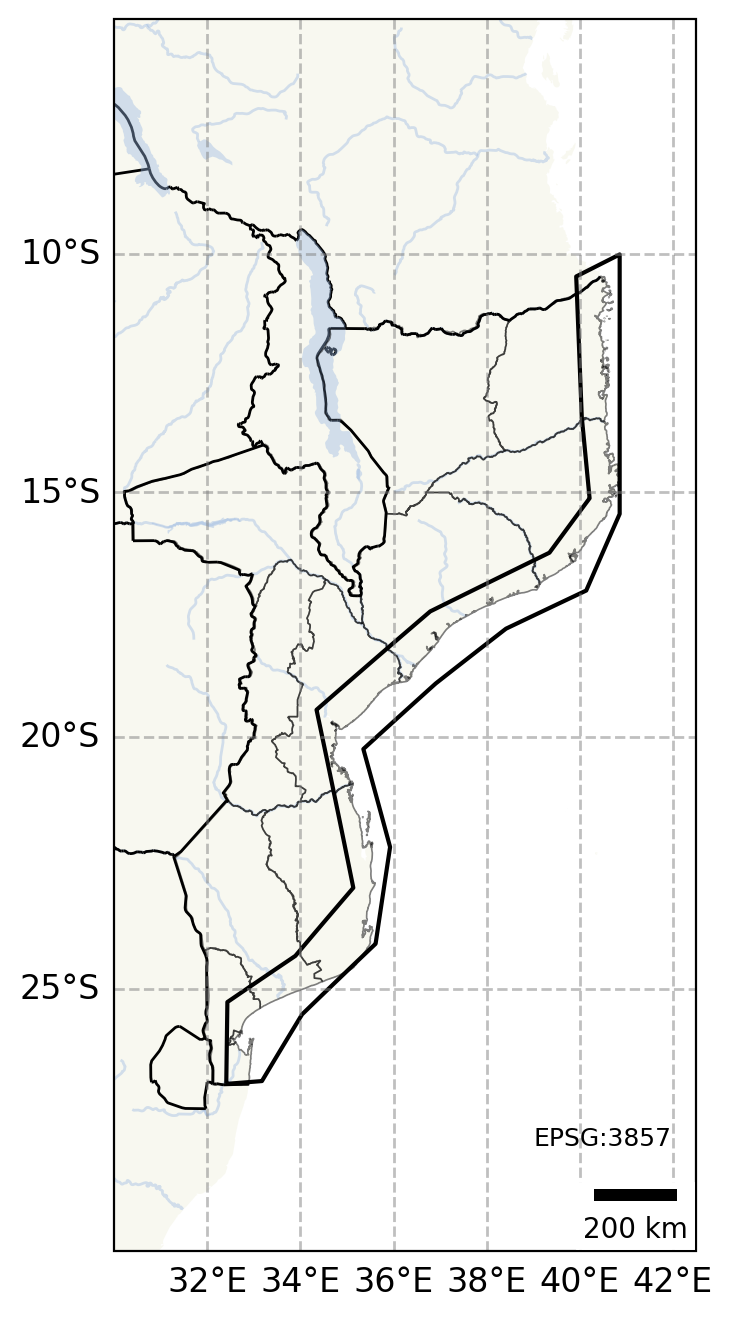

In [42]:
fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.epsg(3857))
gdf_mercator.boundary.plot(ax=ax, edgecolor='k')
adm_mercator.boundary.plot(ax=ax, edgecolor='k',linewidth=0.6,alpha=0.5)
ax.add_feature(cfeat.LAND,alpha=0.4)
ax.add_feature(cfeat.RIVERS,alpha=0.4)
ax.add_feature(cfeat.BORDERS)
ax.add_feature(cfeat.LAKES,alpha=0.4)

ax.set_extent([30, 42.5, -30, -5], crs=ccrs.PlateCarree())

# Create gridlines with labeled axes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

# Add the annotation
annotation_text = 'Your Annotation Text'
annotation_x = 39  # Adjust the x-coordinate as needed
annotation_y = -28  # Adjust the y-coordinate as needed
ax.text(annotation_x, annotation_y,'EPSG:3857',transform=ccrs.PlateCarree(),color='black', fontsize=9)
#ax.text(35, -30, 'EPSG:3857',color='black', fontsize=9)

# Add a scale bar
scale1 = ScaleBar(
    dx=1,
    location="lower right",  # in relation to the whole plot
    label_loc="left",
    scale_loc="bottom",  # in relation to the line
)


ax.add_artist(scale1)
plt.show()

### View the results

You can definitely customize the plots to better suit your needs. In this example, we observe that, despite alterations in Mangrove vegetation, the changes may not be as apparent in the second image, possibly due to the relatively smaller number of points (previously identified as 652 for decrease and 1657 for increase) compared to all pixels in the image.

C:\Users\User\AppData\Local\Temp\ipykernel_14040\3344435565.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


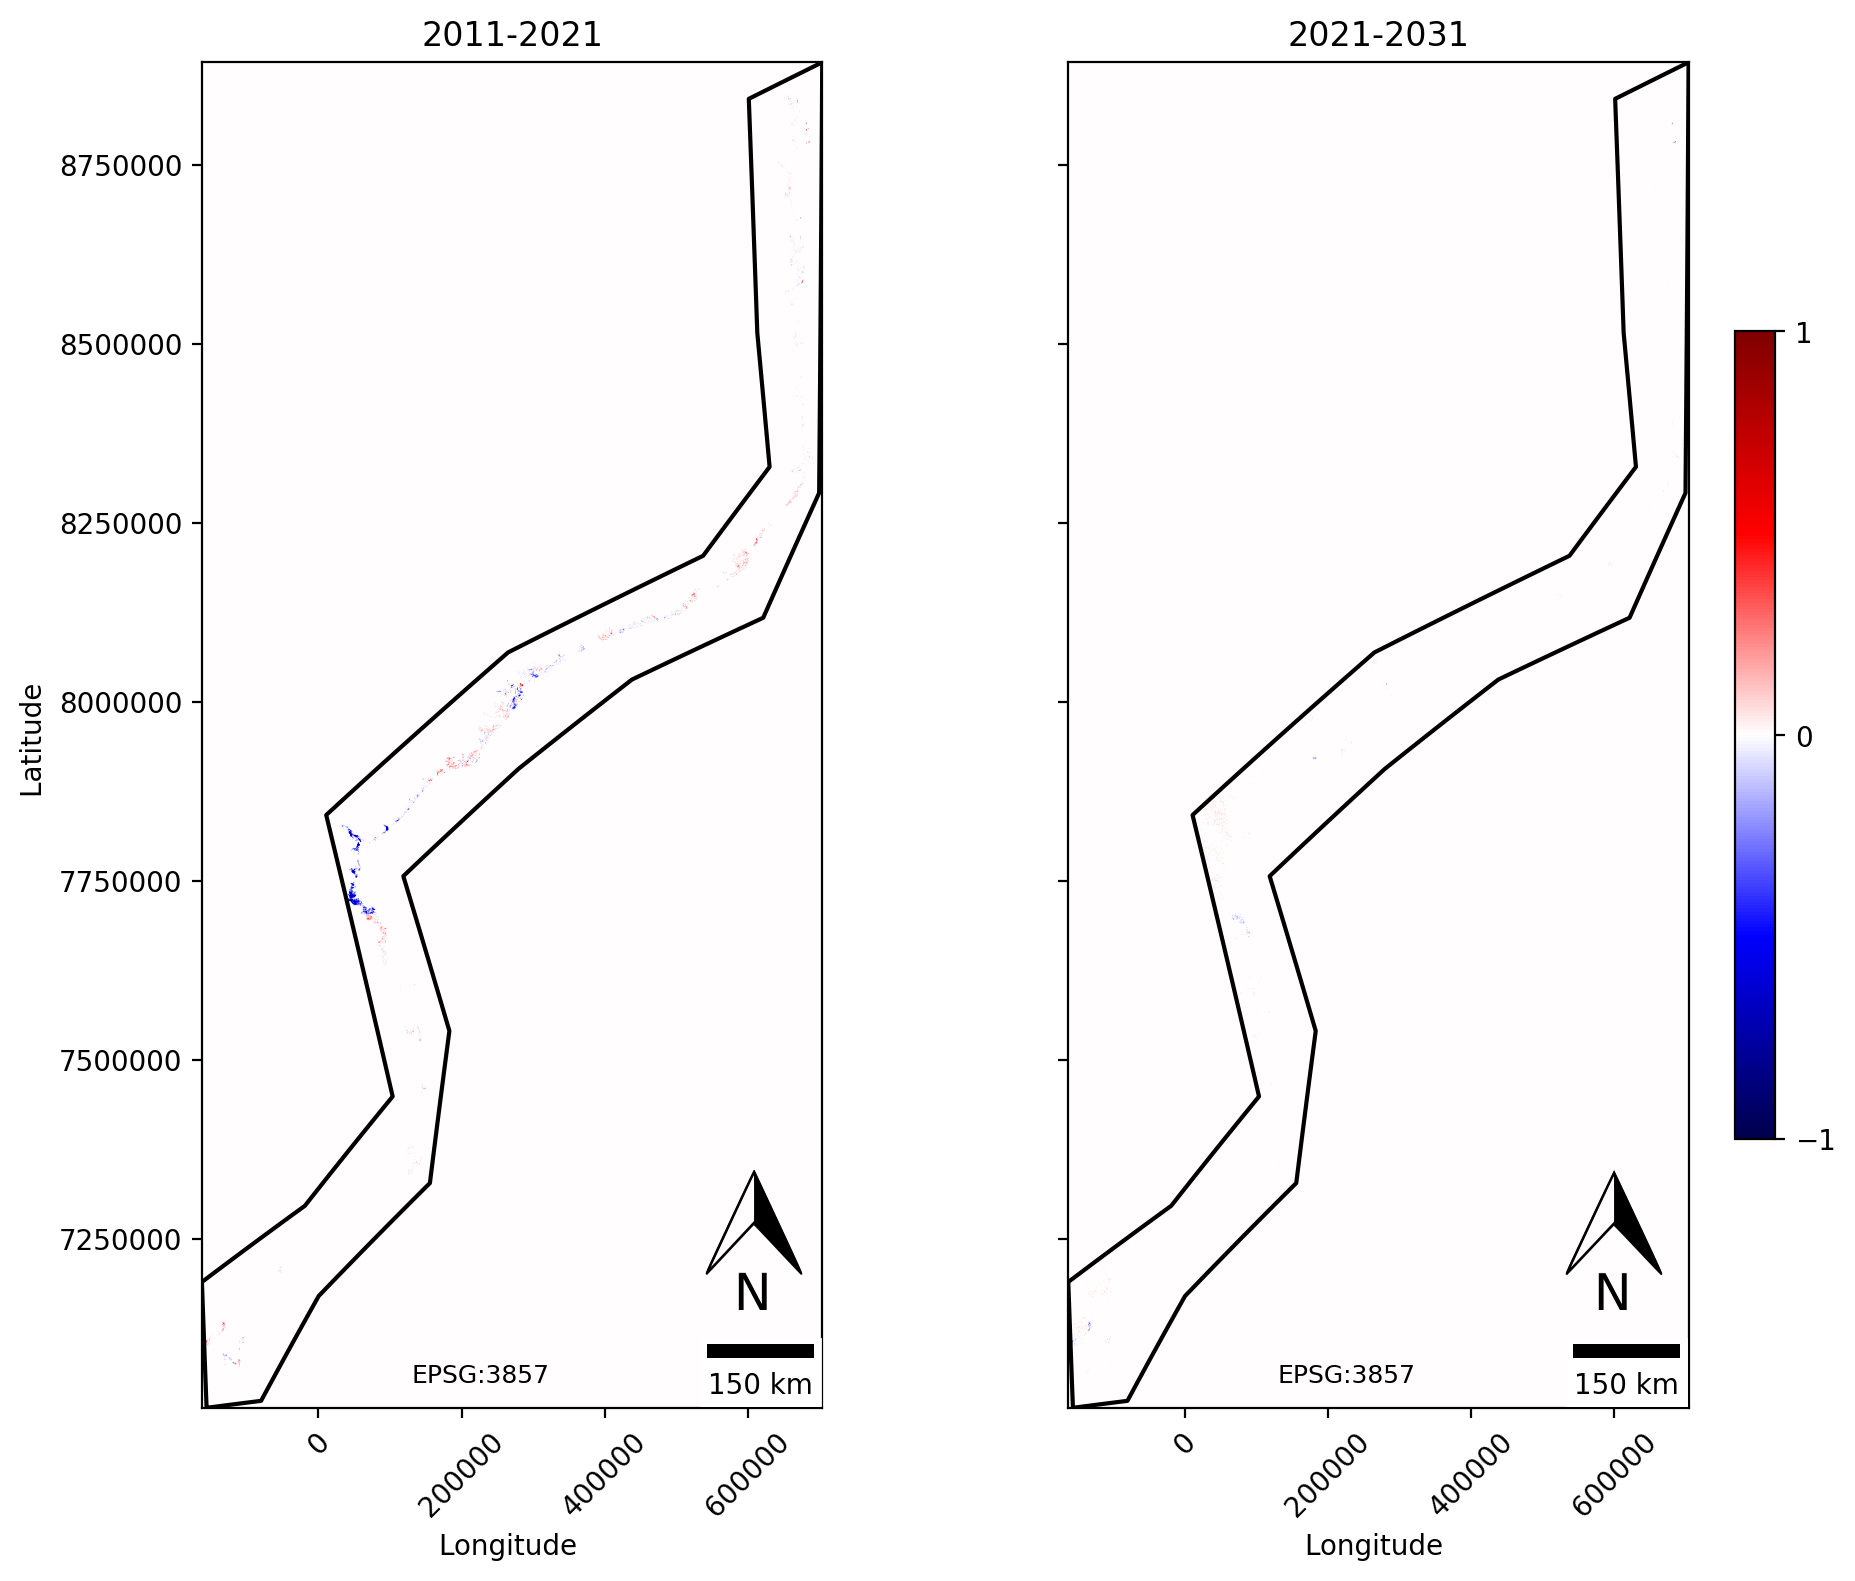

In [61]:
cmap_custom = ListedColormap(['blue', 'white', 'red'])


north_arrow = plt.imread('./north_arrow.png')
fontprops = fm.FontProperties(size=18)


dif_2021_2011_Jan = rasterio.open('./dif_2021_2011_Jan22.tif')
dif_2031_2021_Jan = rasterio.open('./dif_2031_2021_Jan22.tif')
f, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,8))

retted = rasterplot.show(
    dif_2021_2011_Jan,  # plot raster
    extent=dif_2021_2011_Jan.bounds,
    ax=ax1,
    cmap='seismic'
)
ax1.set_ylabel('Latitude ')
ax1.set_xlabel('Longitude ')
ax1.tick_params(axis='x', labelrotation=45)
ax1.get_yaxis().get_major_formatter().set_scientific(False)
ax1.set_title('2011-2021')
#Add the north arrow
# adding the north arrow
newax = f.add_axes([0.39,0.07,0.07,0.30])
newax.imshow(north_arrow)
newax.axis('off')



# Add a scale bar
scale1 = ScaleBar(
    dx=1,
    location="lower right",  # in relation to the whole plot
    label_loc="left",
    scale_loc="bottom",  # in relation to the line
)

ax1.add_artist(scale1)
ax1.text(130000, 7050000, 'EPSG:3857',color='black', fontsize=9)
# Plot shapefiles
gdf.boundary.plot(ax=ax1, edgecolor='k')

# Fig 2

retted2 = rasterplot.show(
    dif_2031_2021_Jan,  # plot raster
    extent=dif_2031_2021_Jan.bounds,
    ax=ax2,
    cmap='seismic'
)
ax2.set_xlabel('Longitude ')
ax2.tick_params(axis='x', labelrotation=45)
ax2.get_yaxis().get_major_formatter().set_scientific(False)
ax2.set_title('2021-2031')
scale2 = ScaleBar(
    dx=1,
    location="lower right",
    label_loc="left",
    scale_loc="bottom",
)

newax2 = f.add_axes([0.82,0.07,0.07,0.30])
newax2.imshow(north_arrow)
newax2.axis('off')

im2 = retted.get_images()[0]
colorbar = f.colorbar(im2, ax=ax2, ticks=[-1, 0, 1],shrink=0.6)


ax2.add_artist(scale2)
ax2.text(130000, 7050000, 'EPSG:3857',color='black', fontsize=9)
# Plot shapefiles
gdf.boundary.plot(ax=ax2, edgecolor='k')
plt.tight_layout()
# plt.savefig('comparacao')
plt.show()

# Training a second model: SVM

Training another algorithm is straightforward, so I'll provide a concise code snippet that I've used. Feel free to experiment with different parameters or models.

In [ ]:
# %%time

# # Initialize the SVM classifier with desired hyperparameters
# svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)  # You can adjust kernel and C as needed

# # Fit the SVM model to the training data
# svm_classifier.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred_svm = svm_classifier.predict(X_test)

# y_pred_prob_svm = svm_classifier.decision_function(X_test)

# # save the model
# filename = 'SVM_xx_xx.sav'
# joblib.dump(svm_classifier, filename)

# # Compute the confusion matrix and print it
# cm = confusion_matrix(y_test, y_pred_svm)
# print('Confusion matrix\n\n', cm)

# # Print the classification report
# print(classification_report(y_test, y_pred_svm))